In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [3]:
from langchain.tools import Tool
from typing import Callable

class DynamicToolRegistry:
    def __init__(self):
        self.tools = {}

    def add_tool(self, name: str, func: Callable, description: str = "No description provided"):
        """Add a tool dynamically."""
        self.tools[name] = func

    def remove_tool(self, name: str):
        """Remove a tool dynamically."""
        if name in self.tools:
            del self.tools[name]

    def get_tools(self):
        """Return all currently available tools."""
        return list(self.tools.values())

# Initialize registry
tool_registry = DynamicToolRegistry()

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def division(a: int, b: int) -> int:
    """Sin of x.
    
    Args:
        x: first int
    """
    return a / b

# Add tools dynamically
tool_registry.add_tool("multiply", multiply)
# tool_registry.add_tool("division", division)
tool_registry.add_tool("add", add)

In [4]:
tool_registry.remove_tool("division")

In [5]:
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    pass

In [39]:
import json 
from langchain_core.messages import ToolMessage

def tool_execution_node(state: AgentState) -> AgentState:
    """Executes the requested tool dynamically."""
    # Get the last AI message
    last_message = state["messages"][-1]
    print("executing tool last_message", last_message)

    # Extract tool calls
    tool_calls = last_message.additional_kwargs.get("tool_calls", [])
    available_tools = tool_registry.get_tools()

    print("tool_calls", tool_calls)

    tool_call = tool_calls[0].get("function")  # Assuming single tool call per message
    tool_name = tool_call["name"]
    tool_args = json.loads(tool_call["arguments"])

    # Fetch available tools
    available_tools = tool_registry.tools
    print("available tool", available_tools)  # Ensure this function exists

    if tool_name in available_tools:
        tool = available_tools[tool_name]
        print("tool_args", tool_args)

        # Ensure arguments are passed as keyword arguments
        result = tool(**tool_args)
        return {"messages" : ToolMessage(content=result, tool_call_id=tool_calls[0].get("id"))}
    else:
        return {"messages" : f"Tool '{tool_name}' not found."}



In [40]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

prompt = """You are a helpful assistant tasked with performing arithmetic on a set of inputs.  
**Instructions:**  
- Do not perform arithmetic actions directly without a tool.
- Determine if you have a tool to perform required arithmetic action. If no tool present respond with: 'Need to create [description of tool].' This will create a new tool to use
- Use existing tools or create new ones to complete the task."""

sys_msg = SystemMessage(content= prompt) 
def assistant(state: AgentState):
    # print("assistan",state["tool_all"])
    print("toolzaa 1: ",tool_registry.get_tools() )
    llm_with_tools = llm.bind_tools(tool_registry.get_tools(), parallel_tool_calls=False)
    output={"messages": [llm_with_tools.invoke(([sys_msg]) + state["messages"])]}
    return output

In [42]:
import tkinter as tk
import ast
import re
from tkinter import simpledialog

def extract_code(ai_message):
    """Extracts Python code from a string with markdown formatting."""
    code_blocks = re.findall(r"```python\n(.*?)```", ai_message, re.DOTALL)
    return code_blocks[0] if code_blocks else None

def get_function_name_from_string(func_code: str):
    """Extracts the function name from a string containing Python code."""
    match = re.search(r"def\s+(\w+)\s*\(", func_code)
    return match.group(1) if match else None  # Return function name if found

def large_text_input(title="new", prompt="new", initial_text=""):
    """Create a larger input window with a multi-line Text widget."""
    def on_submit():
        nonlocal user_input
        user_input = text_widget.get("1.0", tk.END).strip()  # Get text
        root.destroy()  # Close window

    root = tk.Tk()
    root.title(title)
    root.geometry("600x400")  # Set window size
    root.resizable(True, True)  # Allow resizing

    tk.Label(root, text=prompt, font=("Arial", 12)).pack(pady=10)

    text_widget = tk.Text(root, wrap="word", font=("Arial", 12), height=10, width=60)
    text_widget.pack(padx=10, pady=10)
    text_widget.insert("1.0", initial_text)  # Pre-fill text area

    submit_button = tk.Button(root, text="Submit", command=on_submit)
    submit_button.pack(pady=10)

    user_input = None
    root.mainloop()
    return user_input

In [83]:

contrent1 = "You are an experienced Python programmer. Your task is to write a genric python function for given problem statement."
prompt1 =  f"""
    The function should:
    - Have type hints.
    - Include a proper docstring.
    - Doc example: Adds a and b.

                        Args:
                            a: first int
                            b: second int
    -Return the function code without explanations.
    """
sys_msg2 = SystemMessage(content= contrent1, prompt = prompt1)
def tool_creater(state: AgentState):
    try:
        
        output={"message": [llm.invoke(([sys_msg2]) + [state['messages'][-1]])]}
        real_output = large_text_input(initial_text=extract_code(output["message"][0].content))
        exec(real_output, globals())
        func_name = get_function_name_from_string(real_output)
        print(func_name)
        tool_registry.add_tool(func_name, globals().get(func_name))
        return
    except Exception as e:
        print(e)
        return 

In [84]:
def tool_selector(state: AgentState) -> str:
    """Conditional edge function to select the correct path."""
    
    last_message = state["messages"][-1]
    # print(last_message)
    if "need to create" in last_message.content.lower():
        return "tool_creater"
    # If it's a tool call, route to tools
    elif hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "__end__"

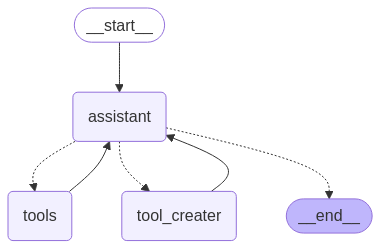

In [85]:
from langgraph.graph import START, StateGraph
# from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(AgentState)

builder.add_node("assistant", assistant)
builder.add_node("tools", tool_execution_node)
builder.add_node("tool_creater", tool_creater)

builder.add_edge(START, "assistant")
builder.add_edge("tools", "assistant")
builder.add_edge("tool_creater", "assistant")

builder.add_conditional_edges(
    "assistant",
    tool_selector
)
# builder.add_edge("tools", "assistant")
# builder.add_edge("tool_creater", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [94]:
messages = [HumanMessage(content="Add 13 to 7. Give sin of that. You dont have a tool for sin")]
messages = react_graph.invoke({"messages": messages})



toolzaa 1:  [<function multiply at 0x7fa67c66bd80>, <function add at 0x7fa665b434c0>, <function division at 0x7fa61125d300>]
executing tool last_message content='' additional_kwargs={'tool_calls': [{'id': 'call_1iQ7gcoPByX74Z06DZNyEIAI', 'function': {'arguments': '{"a":13,"b":7}', 'name': 'add'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 226, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6cda580b-221b-4b6a-af46-1f96b0ac81ee-0' tool_calls=[{'name': 'add', 'args': {'a': 13, 'b': 7}, 'id': 'call_1iQ7gcoPByX74Z06DZNyEIAI', 'type': 'tool_call'}] usage_metadata={'input_tokens': 226, 'output_tokens': 18, 'total_tokens': 244

In [93]:
print(tool_registry.tools)
tool_registry.remove_tool("my_sine")

import math

def calculate_sine(angle_in_radians):
    return math.sin(angle_in_radians)

{'multiply': <function multiply at 0x7fa67c66bd80>, 'add': <function add at 0x7fa665b434c0>, 'division': <function division at 0x7fa61125d300>, 'my_sine': <function my_sine at 0x7fa610225ee0>}


In [95]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 13 to 7. Give sin of that. You dont have a tool for sin
================================== Ai Message ==================================
Tool Calls:
  add (call_1iQ7gcoPByX74Z06DZNyEIAI)
 Call ID: call_1iQ7gcoPByX74Z06DZNyEIAI
  Args:
    a: 13
    b: 7
================================= Tool Message =================================

20
================================== Ai Message ==================================

Need to create a tool for sin.
================================== Ai Message ==================================
Tool Calls:
  calculate_sine (call_T5b4z8HK6RrQz9CcYaGveckJ)
 Call ID: call_T5b4z8HK6RrQz9CcYaGveckJ
  Args:
    angle_in_radians: 20
================================= Tool Message =================================

0.9129452507276277
================================== Ai Message ==================================

The sine of the sum of 13 and 7 is approximately 0.913.
